# Clustering : DBSCAN

**Density Based Spatial Clustering of Applications with Noise** (abbreviated as DBSCAN) is a density-based unsupervised clustering algorithm. 

In [1]:
import torch
torch.manual_seed(42);

## Create data (synthetic)

In [19]:
n_clusters=6
n_samples=[250,300,75,125,500,400] # this is needed to have clusters of different size
assert n_clusters==len(n_samples)

To generate our data, we're going to pick 6 random points, which we'll call centroids, and for each point we're going to generate 250 random points about it.

In [20]:
#centroids = torch.randint(-35, 35, (n_clusters, 2)).float()
centroids = torch.rand(n_clusters, 2)*70-35

In [21]:
from torch.distributions.multivariate_normal import MultivariateNormal
from torch import tensor

In [22]:
def sample(m,n_samples): return MultivariateNormal(m, torch.diag(tensor([5.,5.]))).sample((n_samples,))

slices,labels = zip(*[(sample(c,s),torch.tensor([label]*s)) for label,(c,s) in enumerate(zip(centroids,n_samples))])
data = torch.cat(slices)
labels = torch.cat(labels)
data.shape, labels.shape

(torch.Size([1650, 2]), torch.Size([1650]))

Below we can see each centroid marked w/ X, and the coloring associated to each respective cluster.

In [23]:
import matplotlib.pyplot as plt

In [24]:
def plot_data(centroids, data, n_samples, ax=None):
    if ax is None: _,ax = plt.subplots()
    for i,(c,s) in enumerate(zip(centroids,labels.unique())):
        samples = data[labels==s]
        ax.scatter(samples[:,0], samples[:,1], s=1)
        ax.plot(*c, markersize=10, marker="x", color='k', mew=5)
        ax.plot(*c, markersize=5, marker="x", color='m', mew=2)

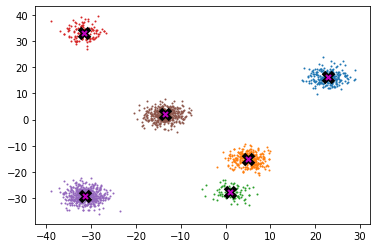

In [25]:
plot_data(centroids, data, labels)

## DBSCAN Algorithm
In DBSCAN, clusters are formed from dense regions and separated by regions of no or low densities.

The randomly selected data point p is called a **core point** if there are more than a minimum number of points (minPts) within a ε-neighborhood of p.<br>
A data point is called a **border point** if it is within a ε-neighborhood of p and it has fewer than the minimum number of points (minPts) within its ε-neighborhood.<br>
If a point that is not a core point or border point is called a **Noise point (Outlier)**.<br> 
A point x is **directly density reachable** from point p if a point p is a core point and x is in p’s ε-neighborhood. 
A point y is **density reachable** from point p if a point y is directly density reachable to core point x, which is also density reachable to core point p.


STEPS:
- Choose any point p randomly
- Identify all density reachable points from p with ε and minPts parameter
- If p is a core point, create a cluster (with ε and minPts)
- If p is a border point, visit the next point in a dataset
- Continue the algorithm until all points are visited

DBSCAN does not require specifying the number of clusters initially. <br>
However, DBSCAN requires two parameters viz. the **radius of neighborhoods** for a given data point p (eps or ε) <br>
and the minimum number of data points in a given ε-neighborhood to form clusters (minPts).

The DBSCAN algorithm can be abstracted into the following steps:[4]
- Find the points in the ε (eps) neighborhood of every point, and identify the core points with more than minPts neighbors.
- Find the connected components of core points on the neighbor graph, ignoring all non-core points.
- Assign each non-core point to a nearby cluster if the cluster is an ε (eps) neighbor, otherwise assign it to noise.

DBSCAN(dataset, eps, MinPts){
# cluster index
C = 1
for each unvisited point p in dataset {
         mark p as visited
         # find neighbors
         Neighbors N = find the neighboring points of p

         if |N|>=MinPts:
             N = N U N'
             if p' is not a member of any cluster:
                 add p' to cluster C 
}

In [26]:
X = data.clone() # Data
len(X)

1650

In [37]:
import pandas as pd
data = pd.DataFrame(X, columns = ["X", "Y"] )

In [39]:
data.head()

,X,Y
0,24.927757,17.575846
1,22.119335,16.729126
2,26.600422,21.040033
3,21.372105,18.391880
4,20.561390,17.142164


In [42]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

In [43]:
def cluster_with_stack(eps, minPts, df):
    
    #initiating cluster number
    C = 1
    #initiating stacks to maintain
    current_stack = set()
    unvisited = list(df.index)
    clusters = []
    
    
    while (len(unvisited) != 0): #run until all points have been visited

        #identifier for first point of a cluster
        first_point = True
        
        #choose a random unvisited point
        current_stack.add(random.choice(unvisited))
        
        while len(current_stack) != 0: #run until a cluster is complete
            
            #pop current point from stack
            curr_idx = current_stack.pop()
            
            #check if point is core, neighbour or border
            neigh_indexes, iscore, isborder, isnoise = check_core_point(eps, minPts, df, curr_idx)
            
            #dealing with an edge case
            if (isborder & first_point):
                #for first border point, we label it aand its neighbours as noise 
                clusters.append((curr_idx, 0))
                clusters.extend(list(zip(neigh_indexes,[0 for _ in range(len(neigh_indexes))])))
                
                #label as visited
                unvisited.remove(curr_idx)
                unvisited = [e for e in unvisited if e not in neigh_indexes]
    
                continue
                
            unvisited.remove(curr_idx) #remove point from unvisited list
            
            
            neigh_indexes = set(neigh_indexes) & set(unvisited) #look at only unvisited points
            
            if iscore: #if current point is a core
                first_point = False
                
                clusters.append((curr_idx,C)) #assign to a cluster
                current_stack.update(neigh_indexes) #add neighbours to a stack

            elif isborder: #if current point is a border point
                clusters.append((curr_idx,C))
                
                continue

            elif isnoise: #if current point is noise
                clusters.append((curr_idx, 0))
                
                continue
                
        if not first_point:
            #increment cluster number
            C+=1
        
    return clusters
            

In [55]:
#radius of the circle defined as 0.6
eps = 4
#minimum neighbouring points set to 3
minPts = 3

In [46]:
import numpy as np

In [56]:
clustered = cluster_with_stack(eps, minPts, data)

In [57]:
idx , cluster = list(zip(*clustered))

cluster_df = pd.DataFrame(clustered, columns = ["idx", "cluster"])

Text(0, 0.5, 'Y')

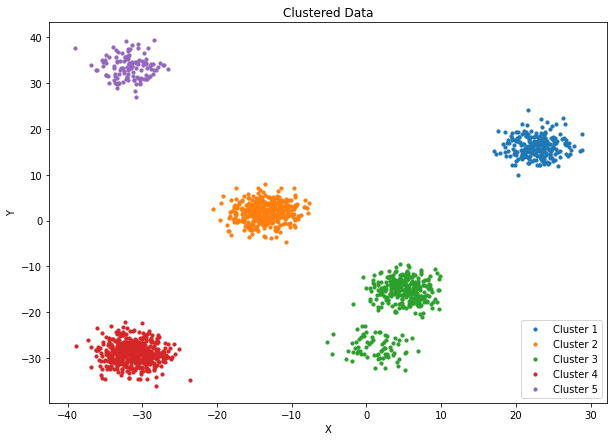

In [58]:
plt.figure(figsize=(10,7))
for clust in np.unique(cluster):
    plt.scatter(X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 0], X[cluster_df["idx"][cluster_df["cluster"] == clust].values, 1], s=10, label=f"Cluster{clust}")

plt.legend([f"Cluster {clust}" for clust in np.unique(cluster)], loc ="lower right")
plt.title('Clustered Data')
plt.xlabel('X')
plt.ylabel('Y')

In [40]:
import random

In [41]:
x = data[random.randint(0, len(X))]  # first point
x

KeyError: 480

In [36]:
x.shape, X.shape

(torch.Size([2]), torch.Size([1650, 2]))

In [ ]:
def check_core_point(eps,minPts, df, index):
    #get points from given index
    x, y = df.iloc[index]['X']  ,  df.iloc[index]['Y']
    
    #check available points within radius
    temp =  df[((np.abs(x - df['X']) <= eps) & (np.abs(y - df['Y']) <= eps)) & (df.index != index)]
    
    #check how many points are present within radius
    if len(temp) >= minPts:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , True, False, False)
    
    elif (len(temp) < minPts) and len(temp) > 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, True, False)
    
    elif len(temp) == 0:
        #return format (dataframe, is_core, is_border, is_noise)
        return (temp.index , False, False, True)

In [41]:
(x-X)[:8]

tensor([[ 0.0000,  0.0000],
        [ 0.5130, -3.8647],
        [-4.2275, -2.3448],
        [ 0.5571, -3.6846],
        [-5.0327, -3.7446],
        [-4.0725, -0.6381],
        [-3.4153, -5.6005],
        [-1.9202, -5.6862]])

In [69]:
# the distance of x to every point in X
%time dist = torch.sqrt(((x-X)**2).sum(1))
dist[:8]

CPU times: user 932 µs, sys: 624 µs, total: 1.56 ms
Wall time: 901 µs


tensor([0.0000, 3.8986, 4.8342, 3.7265, 6.2729, 4.1222, 6.5598, 6.0017])

In [44]:
dist.shape

torch.Size([3000])

In [70]:
#TODO HW: Rewrite using torch.einsum

%time dist2 = 
dist2[:8]torch.einsum('ij->i',(x-X)**2).sqrt()

CPU times: user 795 µs, sys: 759 µs, total: 1.55 ms
Wall time: 861 µs


tensor([0.0000, 3.8986, 4.8342, 3.7265, 6.2729, 4.1222, 6.5598, 6.0017])

In [64]:
from fastcore.test import test_close
test_close(dist, dist2)

In [58]:
weight = gaussian(dist, 2.5)
weight

tensor([1.5958e-01, 4.7304e-02, 2.4606e-02,  ..., 1.4362e-15, 3.0530e-17,
        1.4439e-15])

In [59]:
weight.shape,X.shape

(torch.Size([3000]), torch.Size([3000, 2]))

We now want a weighted average
Formally, the weighted mean of a non-empty finite tuple of data $$\left( x_1, x_2, \dots , x_n \right)$$
with corresponding non-negative weight function|weights $$( w_1, w_2, \dots , w_n)$$ is
$$\bar{x} = \frac{ \sum\limits_{i=1}^n w_i x_i}{\sum\limits_{i=1}^n w_i}$$
which expands to:
$$\bar{x} = \frac{w_1 x_1 + w_2 x_2 + \cdots + w_n x_n}{w_1 + w_2 + \cdots + w_n}.$$

Need to add a trailing axis to the weights to be able to multiply

In [60]:
(weight[:,None]*X)

tensor([[-2.1631e+00, -1.1197e-01],
        [-6.6548e-01,  1.4963e-01],
        [-2.2951e-01,  4.0430e-02],
        ...,
        [-1.4289e-14,  2.7401e-14],
        [-3.3403e-16,  6.2303e-16],
        [-1.2635e-14,  2.7175e-14]])

In [61]:
(weight[:,None]*X).sum(0)/weight.sum()

tensor([-13.2007,   0.8931])

Now all together in a single cell for a single update.

In [71]:
def one_update(X):
    for i, x in enumerate(X):
        #dist = torch.sqrt(((x-X)**2).sum(1))
        dist = torch.einsum('ij->i',(x-X)**2).sqrt()
        #weight = gaussian(dist, 2.5)
        weight = tri(dist, 8)
        X[i] = (weight[:,None]*X).sum(0)/weight.sum()

In [72]:
def meanshift(data):
    X = data.clone()
    for it in range(5): one_update(X)
    return X

In [73]:
%time X=meanshift(data)

CPU times: user 11.5 s, sys: 83.7 ms, total: 11.6 s
Wall time: 1.94 s


We can see that mean shift clustering has almost reproduced our original clustering. The one exception are the very close clusters, but if we really wanted to differentiate them we could lower the bandwidth.

What is impressive is that this algorithm nearly reproduced the original clusters without telling it how many clusters there should be.

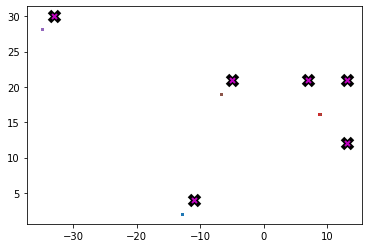

In [75]:
plot_data(centroids+2, X, n_samples)

All the computation is happening in the <tt>for</tt> loop, which isn't accelerated by pytorch. Each iteration launches a new cuda kernel, which takes time and slows the algorithm down as a whole. Furthermore, each iteration doesn't have enough processing to do to fill up all of the threads of the GPU. But at least the results are correct...

We should be able to accelerate this algorithm with a GPU.

## Animation

In [77]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

In [78]:
def do_one(d):
    if not d: return plot_data(centroids+2, X, n_samples, ax=ax)
    one_update(X)
    ax.clear()
    plot_data(centroids+2, X, n_samples, ax=ax)

In [79]:
X = data.clone()
fig,ax = plt.subplots()
ani = FuncAnimation(fig, do_one, frames=5, interval=500, repeat=False)
plt.close()
HTML(ani.to_jshtml())

**Homework:**
implement [k-means clustering](https://en.wikipedia.org/wiki/K-means_clustering), [dbscan](https://en.wikipedia.org/wiki/DBSCAN), 
[locality sensitive hashing](https://en.wikipedia.org/wiki/Locality-sensitive_hashing), 
or some other clustering, fast nearest neighbors, or similar algorithm of your choice, on the GPU. 
Check if your version is faster than a pure python or CPU version.

Bonus: Implement it in APL too!

Super Bonus: Invent a new meanshift algorithm which picks only the closest points to avoid quadratic time.
SB+: Publish it!


In [76]:
STOP: no GPU

SyntaxError: invalid syntax (4015990691.py, line 1)

## GPU batched algorithm

To truly accelerate the algorithm, we need to be performing updates on a batch of points per iteration, instead of just one as we were doing.

In [42]:
def dist_b(a,b): return torch.sqrt(((a[None]-b[:,None])**2).sum(2))

In [43]:
X=torch.rand(8,2)
x=torch.rand(5,2)
dist_b(X, x)

tensor([[0.6161, 0.7434, 0.7351, 0.9002, 0.5875, 0.5845, 0.2929, 0.1938],
        [1.1132, 0.2402, 0.9845, 0.4507, 1.0699, 0.6556, 0.6886, 0.7938],
        [0.0261, 0.9847, 0.3508, 1.0109, 0.0595, 0.5418, 0.4450, 0.4208],
        [0.4530, 0.8696, 0.1635, 0.7858, 0.4366, 0.4354, 0.6171, 0.7125],
        [0.6937, 0.4877, 0.4028, 0.3711, 0.6562, 0.2454, 0.5457, 0.6985]])

In [44]:
bs=5
X = data.clone()
x = X[:bs]
weight = gaussian(dist_b(X, x), 2)
weight

tensor([[1.9947e-01, 1.5541e-01, 5.4735e-02,  ..., 2.2132e-13, 2.0775e-15,
         1.6831e-24],
        [1.5541e-01, 1.9947e-01, 1.1173e-01,  ..., 3.1427e-13, 2.0317e-15,
         9.7350e-25],
        [5.4735e-02, 1.1173e-01, 1.9947e-01,  ..., 3.5939e-16, 9.4595e-19,
         3.9723e-29],
        [7.0175e-02, 3.1377e-02, 1.8560e-02,  ..., 5.2249e-18, 3.3886e-20,
         3.0925e-30],
        [1.4180e-02, 3.1085e-03, 1.1476e-03,  ..., 8.5815e-20, 8.2003e-22,
         9.4978e-32]])

In [45]:
weight.shape,X.shape

(torch.Size([5, 1500]), torch.Size([1500, 2]))

In [46]:
num = (weight[...,None]*X[None]).sum(1)
num.shape

torch.Size([5, 2])

In [47]:
div = weight.sum(1, keepdim=True)
div.shape

torch.Size([5, 1])

In [48]:
num/div

tensor([[-0.5274, 24.3688],
        [-1.0042, 23.6233],
        [-0.7959, 22.5723],
        [ 1.0092, 24.4519],
        [ 1.8587, 25.1916]])

In [49]:
from fastcore.all import chunked

In [50]:
def meanshift(data, bs=500):
    n = len(data)
    X = data.clone()
    for it in range(5):
        for i in range(0, n, bs):
            s = slice(i, min(i+bs,n))
            weight = gaussian(dist_b(X, X[s]), 2)
            num = (weight[...,None]*X[None]).sum(1)
            div = weight.sum(1, keepdim=True)
            X[s] = num/div
    return X

Although each iteration still has to launch a new cuda kernel, there are now fewer iterations, and the acceleration from updating a batch of points more than makes up for it.

In [51]:
data = data.cuda()

In [54]:
X = meanshift(data).cpu()

In [55]:
%timeit -n 1 X = meanshift(data).cpu()

3.25 ms ± 290 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


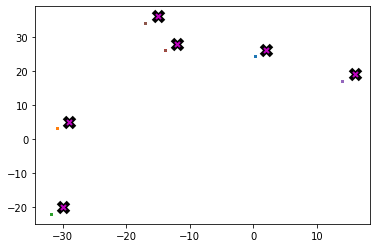

In [56]:
plot_data(centroids+2, X, n_samples)